In [1]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [2]:
!pip install -U fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199774 sha256=27c56a949e58e3a3d5909aa8a799d5c7b056450be74d7c3e9fdebca7e5d274fc
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [3]:
!nvidia-smi

Sun Feb 18 20:53:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Load the dataset

In [4]:
!wget https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
!tar xzf review_polarity.tar.gz

--2024-02-18 20:53:18--  https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  1.90MB/s    in 1.6s    

2024-02-18 20:53:21 (1.90 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



In [5]:
import os
from sklearn.datasets import load_files


dataset_path = 'txt_sentoken'
movie_reviews = load_files(container_path = dataset_path, encoding = 'utf-8')


x = movie_reviews.data            #the data
y = movie_reviews.target          #the labels
z = movie_reviews.target_names    #the names of labels

In [6]:
x[:1]

["arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

In [7]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [8]:
z

['neg', 'pos']

In [9]:
def average_doc_length(corpus):
    ''' Takes as input a whole corpus
      Returns the average number of words and chars per document '''

    document_word_lengths = [len(doc.split()) for doc in corpus]                            #length of each doc (in words)
    average_doc_length_words = sum(document_word_lengths) / len(document_word_lengths)      #average doc length (in words)

    document_char_lengths = [len(doc) for doc in corpus]                                    #length of each doc (in characters)
    average_doc_length_chars = sum(document_char_lengths) / len(document_char_lengths)      #average doc length (in characters)

    return average_doc_length_words, average_doc_length_chars

In [10]:
print("---Before preprocessing---")
avg_length_words, avg_length_chars = average_doc_length(x)
print("Average Document Length (in words):", avg_length_words)
print("Average Document Length (in characters):", avg_length_chars)

---Before preprocessing---
Average Document Length (in words): 746.3405
Average Document Length (in characters): 3893.002


##Pre-processing

The english stopwords is a package of 179 words that in general, would not help in a sentiment analysis problem. But, since they include terms that are negative, removing them could prove harmful for our case.

e.g. imagine the phrase "I didn't like the film" to end up "like film".

So, the plan is to remove all the stop words that include negative meaning before the preprocessing.

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

From these words, we will decide which ones to keep because in fact they have a meaningful impact in our sentiment analysis problem, as we stated earlier.

In [12]:
set_stop_words = set(stopwords.words('english'))

to_keep_words = ['not', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't" , "shouldn't", "haven't", "wasn't", "weren't",  "isn't", "doesn"]
to_keep_words

['not',
 "don't",
 "aren't",
 "couldn't",
 "didn't",
 "doesn't",
 "hadn't",
 "hasn't",
 "shouldn't",
 "haven't",
 "wasn't",
 "weren't",
 "isn't",
 'doesn']

In [13]:
stopwords_updated = set(stopwords.words('english')) - set(to_keep_words)
print(len(stopwords.words('english')))
print(len(to_keep_words))
print(len(stopwords_updated))

179
14
165


In [14]:
from nltk.stem import WordNetLemmatizer
import re
from tqdm.auto import tqdm
import string
nltk.download('wordnet')

def pre_process_text(text):
    ''' Function to preprocess text.
     input: initial text
     output: processed text
     Performs pre-processing methods:
        1. Combination to a single document.
        2. Convertion to lowercase.
        3. Lemmatization and stop words extraction
        4. Punctuation removal
        5. Number removal
        6. Single characters removal
        7. Converting multiple spaces to single ones
        '''
    lemmatizer = WordNetLemmatizer()
    all_docs = []

    single_char = re.compile(r'\s+[a-z]\s+')                                          #6. Remove single characters
    multiple_space= re.compile(r'\s+')                                                 #7. Replace multiple space with a single one

    stopwords_updated = set(stopwords.words('english')) - set(to_keep_words)
    for document in tqdm(x):

        combined_text = ' '.join(text)            #1.Combine in one single document

        combined_text = combined_text.lower()    #2. Convert to lowercase
        combined_text = [lemmatizer.lemmatize(word) for word in document.split() if word not in stopwords_updated]  # 3.Lemmatize and remove stop words


        combined_text = ' '.join(combined_text)

        combined_text = ''.join([char for char in combined_text if char not in string.punctuation])   #4.remove punctuation
        combined_text = ''.join([char for char in combined_text if not char.isdigit()])     #5.remove numbers

        res = single_char.sub(combined_text, '')
        res2 = multiple_space.sub(combined_text, ' ')
        all_docs.append(combined_text)

    return all_docs

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [15]:
processed_text = pre_process_text(x)

processed_text[:1]

  0%|          | 0/2000 [00:00<?, ?it/s]

['arnold schwarzenegger icon action enthusiast  since late s  lately film sloppy oneliner getting worse  hard seeing arnold mr  freeze batman robin  especially say ton ice joke  hey got  million  whats matter  arnold signed another expensive blockbuster  cant compare like terminator series  true lie even eraser  called dark thriller  devil  gabriel byrne  come upon earth  impregnate woman  robin tunney  happens every  year  basically destroy world  apparently god chosen one man  one man jericho cane  arnold   help trusty sidekick  kevin pollack   stop nothing let devil take world  part actually absurd  would fit right dogma  yes  film weak  better blockbuster right  sleepy hollow   make world not enough look like  star film  anyway  definitely doesnt seem like arnold movie  wasnt type film see  sure gave u chuckle well known oneliner  seemed confused character film going  understandable  especially ending changed according source  aside form  still walked  much like past film  im sorry

##Splitting into training set (70%), development set (15%) and test set (15%)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(processed_text, y, test_size=0.3, random_state=17)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=25)

training_text = ' '.join(X_train)                    #Flatten into a single string
development_text = ' '.join(X_dev)
test_text = ' '.join(X_test)

training_words = training_text.split()
development_words = development_text.split()
test_words = test_text.split()

training_vocab = set(training_words)
development_vocab = set(development_words)
test_vocab = set(test_words)

In [17]:
print("Training set size (in documents): ", len(y_train))
print("Development set size (in documents): ", len(y_dev))
print("Test set size (in documents): ", len(y_test))
print("Full size (sanity check): ", len(y_train) + len(y_dev) + len(y_test))
print("---------------------------------")
print("Training vocabulary size (in words): " , len(training_vocab))
print("Development vocabulary size (in words): ", len(development_vocab))
print("Test vocabulary size (in words): ", len(test_vocab))
print("Full vocabulary size (in words): ", len(training_vocab) + len(development_vocab) + len(test_vocab))

Training set size (in documents):  1400
Development set size (in documents):  300
Test set size (in documents):  300
Full size (sanity check):  2000
---------------------------------
Training vocabulary size (in words):  36624
Development vocabulary size (in words):  16948
Test vocabulary size (in words):  16780
Full vocabulary size (in words):  70352


In [18]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

print(STOP_WORDS)
print(len(STOP_WORDS))
extra_to_keep = ["n't", "not", "no"]
for i in range(len(extra_to_keep)):
  to_keep_words.append(extra_to_keep[i])

to_keep_words


{'hereupon', '‘d', '’re', 'again', 'two', 'mostly', 'together', 'any', 'first', 'side', 'that', 'whole', 'still', 'here', 'hers', 'we', 'sixty', 'other', '’s', 'more', 'whether', 'there', 'the', 'eleven', 'everywhere', 'every', 'nor', 'will', 'from', 'than', 'nowhere', 'four', 'formerly', 'can', 'not', 'this', 'beside', 'was', 'behind', 'ever', 'both', 'indeed', 'she', 'besides', 'mine', 'perhaps', 'part', 'everyone', 'whose', 'above', 'all', 'while', 'where', 'myself', 'least', 'whereby', 'anyway', 'on', 'someone', 'even', 'they', 'you', 'seeming', 'amount', 'us', 'full', 'alone', 'across', 'always', 'none', 'himself', "'ve", 'ca', 'below', '‘ll', 'as', 'what', 'if', 'somewhere', 'whom', 'anywhere', 'had', 'via', 'please', 'under', 'fifty', 'seems', 'except', 'become', 'serious', 'during', 'noone', 'be', 'ourselves', 'less', 'some', 'once', 'rather', 'anyhow', 'very', 'show', 'to', 'up', 'most', 'sometime', 'namely', 'his', 'six', 'take', 'others', 'in', 'became', 'make', '‘ve', 'move

['not',
 "don't",
 "aren't",
 "couldn't",
 "didn't",
 "doesn't",
 "hadn't",
 "hasn't",
 "shouldn't",
 "haven't",
 "wasn't",
 "weren't",
 "isn't",
 'doesn',
 "n't",
 'not',
 'no']

In [19]:
stop_words_updated = STOP_WORDS - set(to_keep_words)
print(len(stop_words_updated))

323


In [20]:
nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser","ner"])
nlp.add_pipe('sentencizer')

##Use spaCy for sentence splitting & tokenization

In [21]:
def tokenize_sent(x):

  X_tokenized = []
  for idx in tqdm(range(len(x))):
    doc = nlp(x[idx])
    tokens = []
    for sent in doc.sents:
      for tok in sent:
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in stop_words_updated or tok.text in string.punctuation or all(x in string.punctuation for x in tok.text):
          continue
        if tok.text.strip():
          tokens.append(tok.text.replace('"',"'").strip().lower())
    X_tokenized.append(tokens)
  return X_tokenized

In [22]:
X_train_tokenized = tokenize_sent(X_train)
X_dev_tokenized = tokenize_sent(X_dev)
X_test_tokenized = tokenize_sent(X_test)

  0%|          | 0/1400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [23]:
import numpy as np

print("Total word length before tokenization:", [len(x) for x in X_train])
print("Total word length after tokenization:", [len(x) for x in X_train_tokenized])

print("-----------------------------------------------------------")

print("Average word length before tokenization:", np.mean([len(x) for x in X_train]))
print("Average word length after tokenization:", np.mean([len(x) for x in X_train_tokenized]))

Total word length before tokenization: [1910, 4209, 3093, 1382, 1574, 1239, 4053, 1042, 6206, 2550, 2693, 4096, 3678, 2388, 943, 2316, 2228, 4459, 4586, 2112, 2227, 2743, 1606, 791, 2321, 2903, 2693, 4476, 3583, 2241, 2490, 1719, 2804, 3176, 1336, 800, 5545, 2102, 2411, 4811, 2947, 2195, 1294, 1774, 2754, 1520, 3547, 1888, 2094, 1584, 4735, 1274, 2724, 3922, 1968, 1124, 2736, 3521, 2311, 2329, 2434, 4925, 1544, 2104, 935, 746, 1455, 593, 2325, 3718, 1768, 2206, 2989, 1180, 3287, 1359, 2650, 2204, 2339, 5212, 5447, 2112, 3601, 2824, 1912, 2388, 1482, 2185, 5191, 2883, 2981, 2002, 3331, 1782, 2157, 2141, 2590, 3800, 3393, 1933, 2925, 2294, 3405, 2047, 1251, 2903, 2111, 2902, 2805, 3191, 2118, 2706, 1877, 1000, 1259, 3983, 4724, 2286, 3712, 1555, 2490, 1256, 2542, 2394, 2488, 3550, 3433, 553, 2682, 2831, 941, 3457, 1049, 5903, 3145, 3218, 2378, 2035, 2661, 2495, 1958, 2728, 2125, 2924, 2159, 3182, 5699, 1172, 2943, 866, 667, 3179, 3595, 2169, 1539, 1868, 3993, 2336, 2226, 2436, 1634, 3292

In [24]:
import numpy as np

# Get mean and std of sequence length
train_mean = np.mean([len(x) for x in X_train_tokenized])
train_std = np.std([len(x) for x in X_train_tokenized])
print("Mean of sequence length on training set:", train_mean)
print("Standard deviation of sequence length on training set:", train_std)

print("-----------------------------------------------------------")

dev_mean = np.mean([len(x) for x in X_dev_tokenized])
dev_std = np.std([len(x) for x in X_dev_tokenized])
print("Mean of sequence length on development set:", dev_mean)
print("Standard deviation of sequence length on development set:", dev_std)

print("-----------------------------------------------------------")

test_mean = np.mean([len(x) for x in X_test_tokenized])
test_std = np.std([len(x) for x in X_test_tokenized])
print("Mean of sequence length on test set:", test_mean)
print("Standard deviation of sequence length on test set:", test_std)

Mean of sequence length on training set: 312.97285714285715
Standard deviation of sequence length on training set: 134.5485652324931
-----------------------------------------------------------
Mean of sequence length on development set: 315.10333333333335
Standard deviation of sequence length on development set: 139.33664027176133
-----------------------------------------------------------
Mean of sequence length on test set: 305.0566666666667
Standard deviation of sequence length on test set: 131.16630711513616


In [25]:
print(X_train[0])
print(X_train_tokenized[0])


not many people know james whale  safe bet good chunk seen movie  believe semi biographical god monster  whale would wanted way  insightful  haunting exploration last day frankenstein bride frankenstein director  notable introducing one first complicated gay character hollywood movie  god monster interest biopic whales life track final day life  probably better movie  focus whales  ian mckellen  untraditional deceptive lust heterosexual gardener clayton boone  brendan fraser   begin whale  fairly talented artist  aside director  asking boone  sit    pose portrait   first  boone doesnt realize whale gay grows fascinated old man  discover whales sexual orientation dedicated protective maid  lynn redgrave   frightened  refusing sit guy  come back  storm  disgusted whales  locker room talk   boone return yet another time  whale promise tone aforementioned  locker room talk   find platonic relationship strengthening  meanwhile  jimmy suffering hallucination mental attack result stroke not l

##Tokenize, convert text (sequence of words) to sequence of indexes and PAD the sequences

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math

MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH =  math.ceil(train_mean + train_std)
EMBEDDING_DIM = 300              #to be changed

tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token ='UNK')
tokenizer.fit_on_texts([" ".join(x) for x in X_train_tokenized])

word_idx = tokenizer.word_index


In [27]:
print("Number of unique words in the word index: ", len(word_idx))

Number of unique words in the word index:  36337


In [28]:
train_sequences = tokenizer.texts_to_sequences([" ".join(x) for x in X_train_tokenized])
dev_sequences = tokenizer.texts_to_sequences([" ".join(x) for x in X_dev_tokenized])
test_sequences = tokenizer.texts_to_sequences([" ".join(x) for x in X_test_tokenized])

train_pad = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding ='post')
dev_pad = pad_sequences(dev_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding ='post')
test_pad = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding ='post')

In [29]:
print(train_sequences[0])
print("------------------------------")
print(train_pad[0])

[5, 21, 19, 172, 2072, 1378, 1887, 11, 4996, 47, 3, 226, 10828, 12688, 363, 567, 2072, 615, 13, 3289, 1486, 4069, 45, 2294, 2744, 2294, 34, 1888, 4491, 2295, 1015, 7, 110, 3, 363, 567, 343, 9480, 7054, 14, 715, 206, 45, 14, 114, 46, 3, 524, 7054, 1983, 15531, 20585, 12689, 4492, 6522, 7684, 6523, 4493, 4754, 3290, 106, 2072, 736, 670, 975, 859, 34, 1648, 4493, 765, 3906, 2406, 4493, 4, 593, 2072, 1015, 1349, 4755, 71, 26, 950, 7054, 568, 15532, 3050, 7685, 4494, 8470, 7686, 3742, 4495, 765, 48, 17, 1649, 7687, 7054, 6524, 284, 288, 4493, 302, 9, 2072, 976, 705, 1841, 6524, 284, 288, 37, 20586, 151, 20587, 1431, 2034, 6525, 1790, 688, 244, 3424, 5, 72, 442, 15533, 136, 3743, 4070, 1016, 54, 443, 766, 4493, 20588, 42, 1683, 6526, 363, 567, 4754, 15534, 10829, 24, 212, 2, 5663, 6058, 65, 30, 2838, 2073, 3, 4071, 219, 245, 1159, 4496, 30, 3291, 430, 767, 134, 4072, 10830, 569, 1729, 3290, 224, 276, 847, 463, 1002, 737, 832, 1541, 5, 3292, 12690, 431, 4073, 67, 3907, 1487, 1309, 24, 1350, 4

##Download and unzip fasttext binary model for word embeddings

In [30]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gzip -d cc.en.300.bin.gz

--2024-02-18 20:55:20--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.121, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  19.7MB/s    in 4m 4s   

2024-02-18 20:59:25 (17.6 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



##Create embedding matrix

**Process**: The loop iterates over the word_index dictionary, which contains word-to-index mappings generated by the tokenizer. For each word in the word_index, it checks if the index is within the limit of *MAX_WORDS*. If so, it retrieves the corresponding word vector from the FastText model using *fasttext_model.get_word_vector(word=key)* and assigns it to the corresponding row in the embedding_matrix.

In [31]:
import fasttext

print("Loading embeddings model..")
fasttext_model = fasttext.load_model('cc.en.300.bin')
embedding_matrix = np.zeros(shape=((MAX_WORDS + 2), 300))          # +2 because we have reserved indices for padding and out-of-vocabulary tokens

for key, value in word_idx.items():
    if value <= MAX_WORDS:
        embedding_matrix[value] = fasttext_model.get_word_vector(word=key)            #create embedding matrix

del fasttext_model      #save memory

Loading embeddings model..


##Create one-hot vectors

In [32]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
target_list = z

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_dev_1_hot = lb.transform([target_list[x] for x in y_dev])

#y_train_1_hot = np.argmax(y_train_1_hot, axis=1)
#y_dev_1_hot = np.argmax(y_dev_1_hot, axis=1)

#print('y_dev_1_hot:', y_dev_1_hot)                             #prints vertically
print('y_dev_1_hot:', ' '.join(map(str, y_dev_1_hot)))          #prints horizontally


y_dev_1_hot: [0] [1] [1] [0] [0] [1] [0] [1] [1] [1] [0] [1] [0] [1] [0] [1] [0] [1] [0] [0] [0] [1] [0] [1] [1] [1] [0] [0] [0] [0] [0] [1] [0] [0] [1] [1] [1] [0] [1] [1] [1] [0] [1] [1] [1] [1] [0] [0] [1] [0] [0] [0] [0] [1] [1] [1] [0] [0] [0] [0] [1] [1] [1] [1] [0] [0] [0] [0] [0] [0] [1] [0] [1] [1] [0] [1] [1] [0] [1] [0] [0] [0] [1] [0] [1] [1] [1] [0] [1] [1] [0] [0] [0] [0] [0] [1] [0] [1] [1] [0] [1] [0] [0] [1] [1] [1] [0] [0] [0] [0] [1] [0] [1] [0] [1] [0] [0] [1] [0] [1] [0] [0] [0] [0] [0] [1] [0] [0] [0] [0] [0] [0] [1] [0] [1] [0] [0] [0] [0] [0] [0] [0] [0] [1] [1] [0] [1] [0] [1] [1] [1] [1] [1] [0] [0] [0] [0] [1] [0] [1] [0] [1] [0] [1] [0] [1] [0] [1] [1] [1] [0] [0] [0] [1] [0] [0] [1] [1] [1] [1] [1] [1] [1] [0] [0] [1] [0] [0] [0] [1] [1] [1] [1] [1] [1] [1] [1] [1] [0] [1] [1] [0] [0] [0] [0] [1] [0] [1] [0] [1] [0] [1] [0] [0] [1] [1] [1] [1] [0] [0] [0] [0] [0] [1] [1] [1] [0] [1] [1] [1] [0] [0] [0] [0] [1] [0] [1] [0] [1] [1] [0] [0] [1] [0] [0] [0] [0]

In [33]:
import tensorflow as tf

class Metrics(tf.keras.callbacks.Callback):

    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

##Self attention class

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Layer

class SelfAttention(tf.keras.layers.Layer):
  def __init__(self, mlp_layers=0, units=0, dropout_rate=0, return_attention=False, **kwargs):
    super(SelfAttention, self).__init__(**kwargs)
    self.mlp_layers = mlp_layers
    self.mlp_units = units
    self.return_attention = return_attention
    self.dropout_rate = dropout_rate
    self.attention_mlp = self.build_mlp()

  def build_mlp(self):
    mlp = Sequential()
    for i in range(self.mlp_layers):
      mlp.add(Dense(self.mlp_units, activation='relu'))
      mlp.add(Dropout(self.dropout_rate))
    mlp.add(Dense(1))
    return mlp

  def call(self, x, mask=None):
    a = self.attention_mlp(x)
    a = tf.squeeze(a, axis=2)

    if mask is not None:
      mask = tf.keras.backend.cast(mask, tf.keras.backend.floatx())
      a -= 100000.0 * (1.0 - mask)

    a = tf.keras.backend.expand_dims(tf.keras.backend.softmax(a, axis=-1))
    weighted_input = x * a
    result = tf.keras.backend.sum(weighted_input, axis=1)

    if self.return_attention:
      return [result, a]
    return result

In [35]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_dev = tf.keras.utils.to_categorical(y_dev, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

##RNN model

In [36]:

def build_model(hp):
    GRU_SIZE = hp.Int('gru_size', min_value=100, max_value=500, step=50)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)
    mlp_layers = hp.Int('mlp_layers', min_value=1, max_value=5, step=1)
    mlp_units = hp.Int('mlp_units', min_value=64, max_value=512, step=64)

    model = tf.keras.Sequential()

    model.add(
        tf.keras.layers.Embedding(
            MAX_WORDS+2,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            mask_zero=True,
            trainable=False
        )
    )
    model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(
        tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                GRU_SIZE,
                return_sequences=True,
                recurrent_dropout=dropout_rate
            )
        )
    )
    model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(SelfAttention(mlp_layers=mlp_layers, units=mlp_units))

    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["categorical_accuracy"]
    )

    return model

##Hyperparameter search with Keras Tuner

In [37]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.5 MB/s eta 0:00:00


In [51]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_categorical_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner_logs',
    project_name='hyperparameter_tuning_gru_self_attention'
)


tuner.search(
    train_pad,
    y_train,
    validation_data=(dev_pad, y_dev),
    batch_size=256,
    epochs=50,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=True)
    ]
)


best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 07m 51s]
val_categorical_accuracy: 0.8500000238418579

Best val_categorical_accuracy So Far: 0.8500000238418579
Total elapsed time: 00h 42m 40s


In [52]:
best_gru_size = best_hp.get('gru_size')
best_dropout_rate = best_hp.get('dropout_rate')
best_mlp_layers = best_hp.get('mlp_layers')
best_mlp_units = best_hp.get('mlp_units')

print("Best hyperparameters:")
print("GRU Size:", best_gru_size)
print("Dropout Rate:", best_dropout_rate)
print("MLP Layers:", best_mlp_layers)
print("MLP Units:", best_mlp_units)


Best hyperparameters:
GRU Size: 350
Dropout Rate: 0.4
MLP Layers: 5
MLP Units: 448


In [53]:
best_model = tuner.get_best_models(num_models=1)[0]
#best_trial = tuner.get_best_trials(num_trials=1)[0]




In [56]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)

# Train the best model with the full training data
history = best_model.fit(
    train_pad,
    y_train,
    validation_data=(dev_pad, y_dev),
    batch_size=256,
    epochs=50,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50


6/6 [==============================] - 26s 3s/step - loss: 0.6853 - categorical_accuracy: 0.5471 - val_loss: 0.6637 - val_categorical_accuracy: 0.6267
Epoch 2/50
6/6 [==============================] - 19s 3s/step - loss: 0.6523 - categorical_accuracy: 0.6200 - val_loss: 0.6463 - val_categorical_accuracy: 0.6300
Epoch 3/50
6/6 [==============================] - 18s 3s/step - loss: 0.6018 - categorical_accuracy: 0.6857 - val_loss: 0.6787 - val_categorical_accuracy: 0.6333
Epoch 4/50
6/6 [==============================] - 19s 3s/step - loss: 0.5585 - categorical_accuracy: 0.7243 - val_loss: 0.6082 - val_categorical_accuracy: 0.6567
Epoch 5/50
6/6 [==============================] - 18s 3s/step - loss: 0.5404 - categorical_accuracy: 0.7429 - val_loss: 0.6332 - val_categorical_accuracy: 0.6333
Epoch 6/50
6/6 [==============================] - 18s 3s/step - loss: 0.5175 - categorical_accuracy: 0.7464 - val_loss: 0.5793 - val_categorical_accuracy: 0.6767
Epoch 7/50
6/6 [=======================

##Visualize Model's Training History

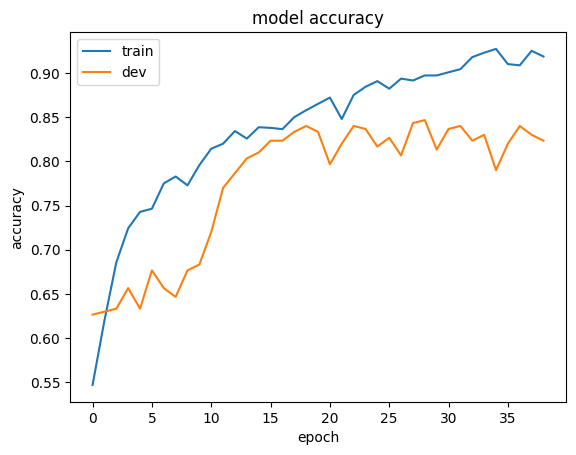

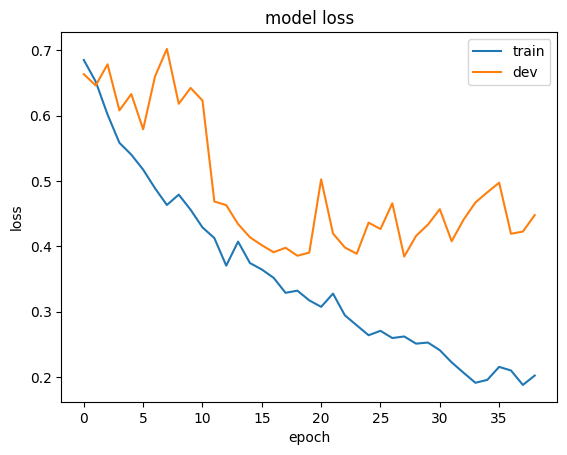

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [61]:
# train: precision, recall, f1
from sklearn.metrics import classification_report


predictions_train = np.argmax(best_model.predict(train_pad, verbose=0), -1)
y_train_ = np.argmax(y_train, -1)
print('Training set')
print('===========')
print(classification_report(y_train_, predictions_train))

# train: auc
'''
auc_class0_test = calculate_class_AUC_score(y_train_, predictions_train, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_train_, predictions_train, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))
'''

Training set
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       690
           1       0.96      0.92      0.94       710

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



"\nauc_class0_test = calculate_class_AUC_score(y_train_, predictions_train, '0')\nprint('class 0 AUC: {0:.3f}'.format(auc_class0_test))\nauc_class1_test = calculate_class_AUC_score(y_train_, predictions_train, '1')\nprint('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))\nprint('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))\n"

In [64]:
predictions_dev = np.argmax(best_model.predict(dev_pad, verbose=0), -1)
y_val_ = np.argmax(y_dev, -1)
print('Validation set')
print('===========')
print(classification_report(y_val_, predictions_dev))

Validation set
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       157
           1       0.89      0.78      0.83       143

    accuracy                           0.85       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.85      0.85       300



In [73]:
predictions_dev = np.argmax(best_model.predict(test_pad, verbose=0), -1)
y_test_ = np.argmax(y_test, -1)
print('Test set')
print('===========')
print(classification_report(y_test_, predictions_dev))

Test set
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       153
           1       0.87      0.80      0.83       147

    accuracy                           0.84       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



##Metrics (Precision, Recall, F1, AUC)

In [66]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc
import numpy as np



train_probs = best_model.predict(train_pad)                       #Predict probs for training,dev and test
dev_probs = best_model.predict(dev_pad)
test_probs = best_model.predict(test_pad)


train_preds = (train_probs > 0.5).astype(int)                                 #To get binary predictions
dev_preds = (dev_probs > 0.5).astype(int)
test_preds = (test_probs > 0.5).astype(int)

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    return precision, recall, f1

train_precision, train_recall, train_f1 = calculate_metrics(y_train, train_preds)
dev_precision, dev_recall, dev_f1 = calculate_metrics(y_dev, dev_preds)
test_precision, test_recall, test_f1 = calculate_metrics(y_test, test_preds)

'''
def calculate_pr_auc(y_true, y_probs):
    pr_auc_scores = []

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc_scores.append(auc(recall, precision))
    return pr_auc_scores

train_pr_auc = calculate_pr_auc(y_train, train_probs)
dev_pr_auc = calculate_pr_auc(y_dev, dev_probs)
test_pr_auc = calculate_pr_auc(y_test, test_probs)
'''

10/10 [==============================] - 7s 690ms/step


'\ndef calculate_pr_auc(y_true, y_probs):\n    pr_auc_scores = []\n\n    precision, recall, _ = precision_recall_curve(y_true, y_probs)\n    pr_auc_scores.append(auc(recall, precision))\n    return pr_auc_scores\n\ntrain_pr_auc = calculate_pr_auc(y_train, train_probs)\ndev_pr_auc = calculate_pr_auc(y_dev, dev_probs)\ntest_pr_auc = calculate_pr_auc(y_test, test_probs)\n'

In [68]:
for i in range(2):
    print("Class ", z[i], ":   (Training)     (Development)      (Test)")
    print(f"Precision    |  {train_precision[i]:.6f}   |    {dev_precision[i]:.6f}    |   {test_precision[i]:.6f}")
    print(f"Recall       |  {train_recall[i]:.6f}   |    {dev_recall[i]:.6f}    |   {test_recall[i]:.6f}")
    print(f"F1-score     |  {train_f1[i]:.6f}   |    {dev_f1[i]:.6f}    |   {test_f1[i]:.6f}")
    #print(f"PR AUC       |  {train_pr_auc[i-1]:.6f}   |    {dev_pr_auc[i-1]:.6f}    |   {test_pr_auc[i-1]:.6f}")
    print("-------------------------------------------------------------")

Class  neg :   (Training)     (Development)      (Test)
Precision    |  0.920723   |    0.817143    |   0.823171
Recall       |  0.959420   |    0.910828    |   0.882353
F1-score     |  0.939674   |    0.861446    |   0.851735
-------------------------------------------------------------
Class  pos :   (Training)     (Development)      (Test)
Precision    |  0.958884   |    0.888000    |   0.867647
Recall       |  0.919718   |    0.776224    |   0.802721
F1-score     |  0.938893   |    0.828358    |   0.833922
-------------------------------------------------------------


In [71]:
def calculate_macro_averaged_scores(y_true, y_pred, y_probs):

    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    def calculate_pr_auc(y_true, y_probs):
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        pr_auc = auc(recall, precision)
        return pr_auc

    #pr_auc = calculate_pr_auc(y_true, y_probs)


    macro_avg_precision = np.mean(precision)
    macro_avg_recall = np.mean(recall)
    macro_avg_f1 = np.mean(f1)
    #macro_avg_pr_auc = np.mean(pr_auc)

    return macro_avg_precision, macro_avg_recall, macro_avg_f1 #, macro_avg_pr_auc

#train_macro_avg_precision, train_macro_avg_recall, train_macro_avg_f1 , train_macro_avg_pr_auc = calculate_macro_averaged_scores(y_train, train_preds, train_probs)
#dev_macro_avg_precision, dev_macro_avg_recall, dev_macro_avg_f1 , dev_macro_avg_pr_auc = calculate_macro_averaged_scores(y_dev, dev_preds, dev_probs)
#test_macro_avg_precision, test_macro_avg_recall, test_macro_avg_f1 , test_macro_avg_pr_auc = calculate_macro_averaged_scores(y_test, test_preds, test_probs)

train_macro_avg_precision, train_macro_avg_recall, train_macro_avg_f1  = calculate_macro_averaged_scores(y_train, train_preds, train_probs)
dev_macro_avg_precision, dev_macro_avg_recall, dev_macro_avg_f1  = calculate_macro_averaged_scores(y_dev, dev_preds, dev_probs)
test_macro_avg_precision, test_macro_avg_recall, test_macro_avg_f1  = calculate_macro_averaged_scores(y_test, test_preds, test_probs)


print("Macro-averaged Scores for Training Subset:")
print("===========================================")
print(f"Macro-averaged Precision: {train_macro_avg_precision:.6f}")
print(f"Macro-averaged Recall: {train_macro_avg_recall:.6f}")
print(f"Macro-averaged F1-score: {train_macro_avg_f1:.6f}")
#print(f"Macro-averaged PR AUC: {train_macro_avg_pr_auc:.6f}")
print()

print("Macro-averaged Scores for Development Subset:")
print("===============================================")
print(f"Macro-averaged Precision: {dev_macro_avg_precision:.6f}")
print(f"Macro-averaged Recall: {dev_macro_avg_recall:.6f}")
print(f"Macro-averaged F1-score: {dev_macro_avg_f1:.6f}")
#print(f"Macro-averaged PR AUC: {dev_macro_avg_pr_auc:.6f}")
print()

print("Macro-averaged Scores for Test Subset:")
print("========================================")
print(f"Macro-averaged Precision: {test_macro_avg_precision:.6f}")
print(f"Macro-averaged Recall: {test_macro_avg_recall:.6f}")
print(f"Macro-averaged F1-score: {test_macro_avg_f1:.6f}")
#print(f"Macro-averaged PR AUC: {test_macro_avg_pr_auc:.6f}")

Macro-averaged Scores for Training Subset:
Macro-averaged Precision: 0.939804
Macro-averaged Recall: 0.939569
Macro-averaged F1-score: 0.939283

Macro-averaged Scores for Development Subset:
Macro-averaged Precision: 0.852571
Macro-averaged Recall: 0.843526
Macro-averaged F1-score: 0.844902

Macro-averaged Scores for Test Subset:
Macro-averaged Precision: 0.845409
Macro-averaged Recall: 0.842537
Macro-averaged F1-score: 0.842829
